# TreePoints - DeepForest Baseline Model

In this notebook, we illustrate the structure of the datasets and performance of the baseline box model against the official training split.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

if os.path.basename(os.getcwd()) == 'examples':
    sys.path.append("../")
    
import milliontrees

We will use the DeepForest bounding box model available at https://deepforest.readthedocs.io/en/latest/user_guide/02_prebuilt.html#tree-crown-detection-model. To turn the box model into predictions, we will use the centroids.

In [2]:
from deepforest import main
m = main.deepforest()
m.load_model("weecology/deepforest-tree")

/blue/ewhite/b.weinstein/miniconda3/envs/MillionTrees/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/blue/ewhite/b.weinstein/miniconda3/envs/MillionTrees/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Reading config file: /blue/ewhite/b.weinstein/miniconda3/envs/MillionTrees/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /blue/ewhite/b.weinstein/miniconda3/envs/MillionTrees/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


    xmin   ymin   xmax   ymax label     score    image_path  \
0  330.0  342.0  373.0  391.0  Tree  0.802979  OSBS_029.png   
1  216.0  206.0  248.0  242.0  Tree  0.778803  OSBS_029.png   
2  325.0   44.0  363.0   82.0  Tree  0.751572  OSBS_029.png   
3  261.0  238.0  296.0  276.0  Tree  0.748605  OSBS_029.png   
4  173.0    0.0  229.0   33.0  Tree  0.738210  OSBS_029.png   

              geometry  
0  POINT (351.5 366.5)  
1      POINT (232 224)  
2       POINT (344 63)  
3    POINT (278.5 257)  
4     POINT (201 16.5)  


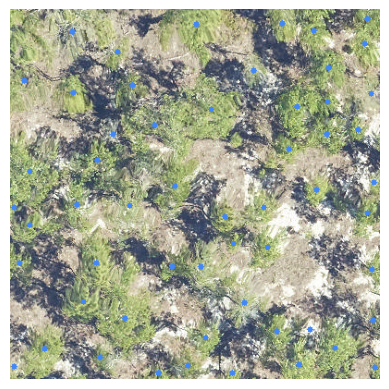

In [3]:
from deepforest import get_data
from deepforest.visualize import plot_results
from deepforest.utilities import read_file

boxes = m.predict_image(path=get_data("OSBS_029.png"))
points = boxes
points["geometry"] = boxes.centroid

print(points.head())
plot_results(points)

In [4]:
# Load the box dataset
from milliontrees import get_dataset
from milliontrees.common.data_loaders import get_eval_loader

point_dataset = get_dataset("TreePoints", root_dir="/orange/ewhite/DeepForest/MillionTrees/")
point_test_data = point_dataset.get_subset("test")

The general workflow is to yield a image, and targets (orange), make a predictions (blue) and evaluate the metric. 

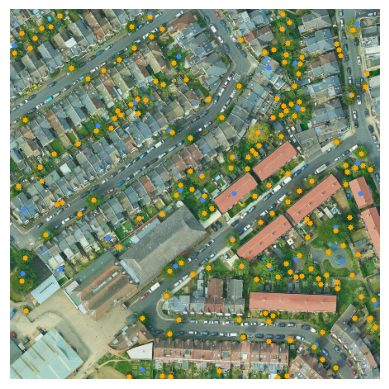

In [5]:
metadata, image, targets = point_test_data[0]
image_path = point_dataset._filename_id_to_code[int(metadata[0])]
image_path = os.path.join(point_dataset._data_dir._str, "images",image_path)

# Load the image, in this case DeepForest expects a numpy array, channels first, 0-255.
channels_first = image.permute(1, 2, 0).numpy() * 255
boxes = m.predict_image(channels_first)
points = boxes
points["geometry"] = boxes.centroid
points[["x","y"]] = points["geometry"].apply(lambda x: pd.Series([x.x, x.y]))
ground_truth = read_file(pd.DataFrame(targets["y"].numpy(),columns=["x","y"]))
ground_truth["label"] = "Tree"
ground_truth["score"] = 1
plot_results(points, ground_truth, image=channels_first.astype("int32"))

## Evaluation example

Every model will output predictions in a slightly different way. MillionTrees expects a dictionary of tensors, same format between predictions and ground truth.

In [ ]:
y_pred = {}
y_pred["y"] = torch.tensor(points[["x", "y"]].values.astype("float32"))
y_pred["labels"] = torch.tensor(boxes.label.apply(
        lambda x: m.label_dict[x]).values.astype(np.int64))
y_pred["scores"] = torch.tensor(boxes.score.values.astype("float32"))

# The eval method takes in batches, so wrap this one example in a list
point_test_data.eval([y_pred], [targets], metadata=torch.unsqueeze(metadata, dim=0))

({'keypoint_acc_avg': 0.17514124512672424,
  'keypoint_acc_source_id:0': 0.17514124512672424,
  'count_source_id:0': 1.0,
  'keypoint_acc_source_id:1': nan,
  'count_source_id:1': 0.0,
  'keypoint_acc_source_id:2': nan,
  'count_source_id:2': 0.0,
  'keypoint_acc_source_id:3': nan,
  'count_source_id:3': 0.0,
  'keypoint_acc_wg': 0.17514124512672424,
  'detection_acc_avg_dom': np.float64(nan)},
 'Average detection_acc across source: nan\nAverage keypoint_acc: 0.175\n  source_id = 0  [n =      1]:\tkeypoint_acc = 0.175\nWorst-group keypoint_acc: 0.175\n')

The evaluation dictionary is broken down by 'sources' which are individual projects contributed to the MillionTrees project, listed on the 'datasets' page on the docs. For each source the dictionary gives a count of the number of images, and then the bounding box mAP accuracy score. Then it gives the average within-group 'wg' score, and the average over all groups. 

For most evaluation workflows there will be some intermediary code to format the output of whatever prediction workflow to the desired eval format. It would also be nice to have a plotting function to see some examples.

In [13]:
import warnings
from deepforest.utilities import read_file

def format_deepforest_prediction(images, metadata, targets, m, batch_index, point_dataset):
    # Suppress user warnings to make more readable
    warnings.filterwarnings("ignore")
        
    images = torch.tensor(images)
    predictions = m.predict_step(images, batch_index)

    batch_results = []
    for image_metadata, pred, image_targets, image in zip(metadata,predictions, targets, images):
        basename = point_dataset._filename_id_to_code[int(image_metadata[0])]
        if pred.empty:
            y_pred = {}
            y_pred["y"] = torch.zeros(1,2)
            y_pred["labels"] = torch.zeros(1)
            y_pred["scores"] = torch.zeros(1)
        else:
            pred.root_dir = os.path.join(point_dataset._data_dir._str, "images")
            pred = read_file(pred)
            pred["geometry"] = pred["geometry"].centroid
            pred[["x","y"]] = pred["geometry"].apply(lambda x: pd.Series([x.x, x.y]))
            pred["image_path"] = basename
            # Reformat to milliontrees format
            y_pred = {}
            y_pred["y"] = torch.tensor(pred[["x","y"]].values.astype("float32"))
            y_pred["labels"] = torch.tensor(pred.label)
            y_pred["scores"] = torch.tensor(pred.score.values.astype("float32"))
        batch_results.append(y_pred)
    
    return batch_results, predictions

# Helper function to plot evaluation results
def plot_eval_results(image_metadata, y_pred, pred, image_targets, image, batch_index):  
    ground_truth = read_file(pd.DataFrame(image_targets["y"].numpy(),columns=["x","y"]))
    ground_truth["label"] = "Tree"
    ground_truth["score"] = 1 
    predictions_df = read_file(pred)
    predictions_df["geometry"] = predictions_df["geometry"].centroid
    predictions_df[["x","y"]] = predictions_df["geometry"].apply(lambda x: pd.Series([x.x, x.y]))
    basename = point_dataset._filename_id_to_code[int(image_metadata[0])]
    predictions_df["label"] = "Tree"
    # Make image channel last
    image = image.permute(1, 2, 0).numpy()  * 255
    accuracy = point_dataset._metric._accuracy(image_targets["y"], y_pred["y"], distance_threshold=0.1)
    plot_results(predictions_df, ground_truth, image=image.astype("int32"))
    print(f"Image: {basename}, index {batch_index} with Detection Accuracy: {accuracy.item():.2f}")

There are 25 batches in the test loader


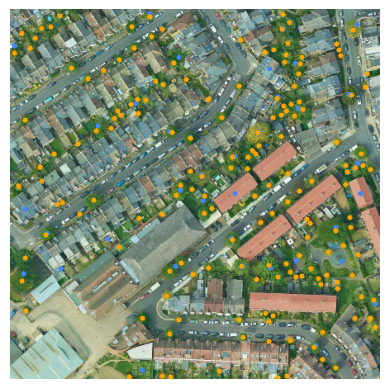

Image: IMG_434.jpg, index 0 with Detection Accuracy: 0.18


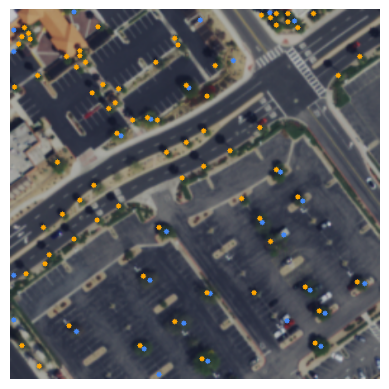

Image: palm_springs_2020_41.tif, index 250 with Detection Accuracy: 0.18


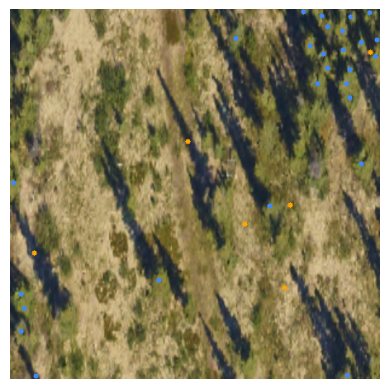

Image: DEJU_050.tif, index 500 with Detection Accuracy: 0.03


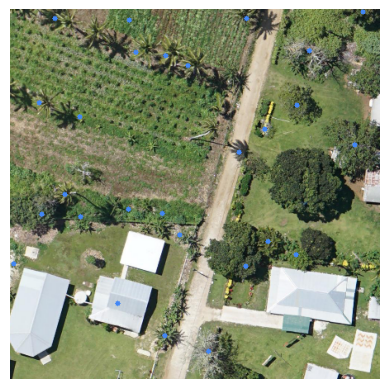

Image: Kolovai-Trees-20180108_254.png, index 750 with Detection Accuracy: 0.00


({'keypoint_acc_avg': 0.1285368651151657,
  'keypoint_acc_source_id:0': 0.17355817556381226,
  'count_source_id:0': 141.0,
  'keypoint_acc_source_id:1': 0.0,
  'count_source_id:1': 76.0,
  'keypoint_acc_source_id:2': 0.019244665279984474,
  'count_source_id:2': 245.0,
  'keypoint_acc_source_id:3': 0.2220272570848465,
  'count_source_id:3': 323.0,
  'keypoint_acc_wg': 0.0,
  'detection_acc_avg_dom': np.float64(nan)},
 'Average detection_acc across source: nan\nAverage keypoint_acc: 0.129\n  source_id = 0  [n =    141]:\tkeypoint_acc = 0.174\n  source_id = 1  [n =     76]:\tkeypoint_acc = 0.000\n  source_id = 2  [n =    245]:\tkeypoint_acc = 0.019\n  source_id = 3  [n =    323]:\tkeypoint_acc = 0.222\nWorst-group keypoint_acc: 0.000\n')

In [14]:
# Get the test loader
test_loader = get_eval_loader("standard", point_test_data, batch_size=32)

# Print the length of the test loader
print("There are {} batches in the test loader".format(len(test_loader)))

# Get predictions for the full test set
all_y_pred = []
all_y_true = []

batch_index = 0
for batch in test_loader:
    metadata, images, targets  = batch
    # Get the original DeepForest, and MillionTrees formatted predictions, this is just for plotting, otherwise you just need y_pred.
    milliontrees_format, deepforest_format = format_deepforest_prediction(images, metadata, targets, m, batch_index, point_dataset)
    for image_metadata, y_pred, pred, image_targets, image in zip(metadata, milliontrees_format, deepforest_format, targets, images):
        # Plot every 250th image
        if batch_index % 250 == 0:
            plot_eval_results(image_metadata, y_pred, pred, image_targets, image, batch_index)
        # Gather all predictions and ground truth
        all_y_pred.append(y_pred)
        all_y_true.append(image_targets)
        batch_index += 1

# Evaluate
point_dataset.eval(all_y_pred, all_y_true, point_test_data.metadata_array)